### Brain Tumor classification using Resnet 50

In [3]:
import tensorflow
from PIL import Image
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, save_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization,Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np 
from tqdm import tqdm
from sklearn.utils import shuffle
import cv2
import os
import shutil
import itertools
import imutils
from sklearn.model_selection import StratifiedKFold
import random
from tensorflow.keras import layers


## Sample Images

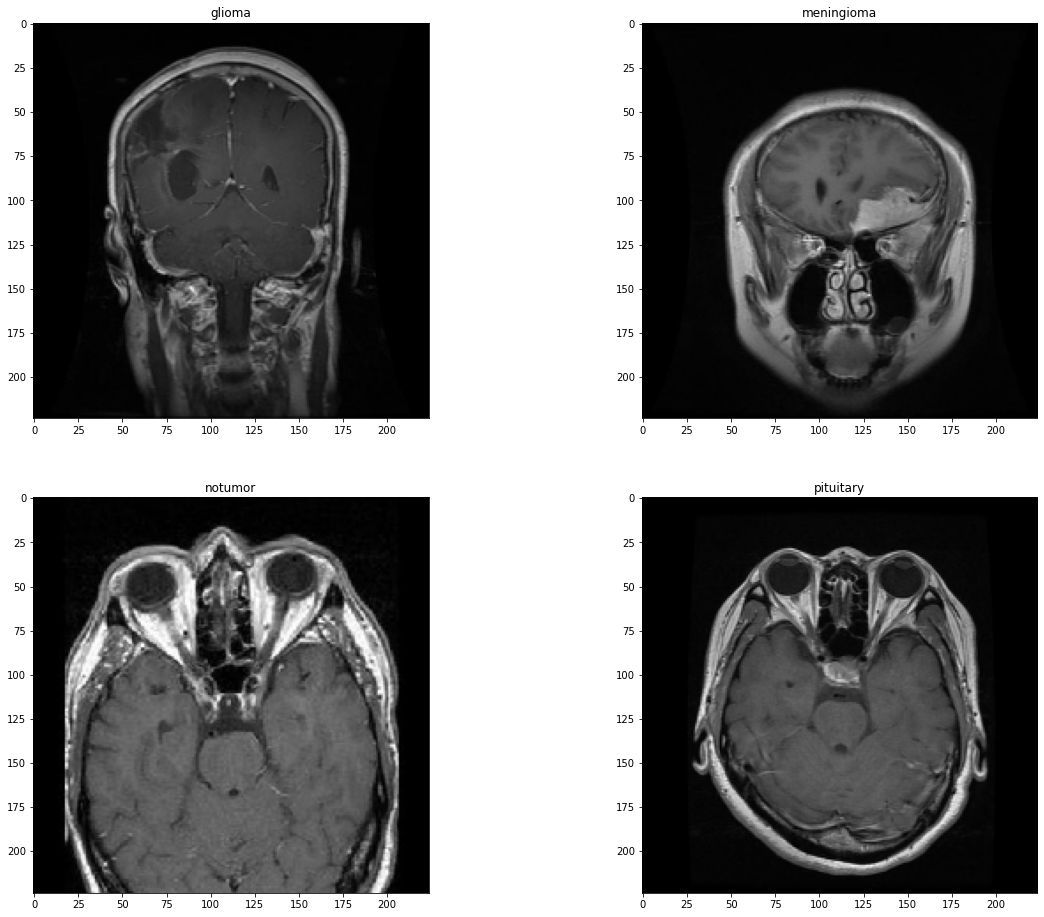

In [5]:
data_dir = ('D:/bt project/temp/temp/brain_tumour_classification-main/brain_tumour/Training')
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
plt.figure(figsize=(20, 16))

images_path = ['/glioma/Tr-gl_0010.jpg', '/meningioma/Tr-meTr_0000.jpg', '/notumor/Tr-noTr_0000.jpg', '/pituitary/Tr-piTr_0000.jpg']

for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    img = cv2.imread(data_dir + images_path[i])
    img = cv2.resize(img, (224, 224))
    plt.imshow(img)
    plt.title(categories[i])

In [8]:
img = cv2.imread('D:/bt project/temp/temp/brain_tumour_classification-main/brain_tumour/Training/meningioma/Tr-me_0010.jpg')
img = cv2.resize(
            img,
            dsize=(224,224),
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

In [12]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

x_train = [] # training images.
y_train  = [] # training labels.
x_test = [] # testing images.
y_test = [] # testing labels.

image_size = 200


for label in labels:
    trainPath = os.path.join('D:/bt project/temp/temp/brain_tumour_classification-main/brain_tumour/Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) # load images in gray.
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images into 150*150.
        x_train.append(image)
        y_train.append(labels.index(label))
    
    testPath = os.path.join('D:/bt project/temp/temp/brain_tumour_classification-main/brain_tumour/Testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))


x_train = np.array(x_train) / 255.0 # normalize Images into range 0 to 1.
x_test = np.array(x_test) / 255.0

print(x_train.shape)
print(x_test.shape)

100%|██████████| 300/300 [00:02<00:00, 138.75it/s]


(5712, 200, 200, 3)
(1311, 200, 200, 3)


## train and validation split

In [13]:
#Shuffling data , so as to ensure no sequential data for more reliable and unbiased predictions
x_train, y_train = shuffle(x_train,y_train, random_state=42) 

#this function returns a binary matrix which has tuples equal to the number of inputs and columns equal to the classes
y_train = tensorflow.keras.utils.to_categorical(y_train) 
y_test = tensorflow.keras.utils.to_categorical(y_test)

#Dividing the dataset into Training and Validation sets.
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) 

print(x_val.shape)

(1143, 200, 200, 3)


## Image Augmentation

-> Results in multiple transformed copies of the same image.


-> Features like : Rotations,Shifts,Flips,Brightness,Zoom

-> These image augmentation techniques not only expand the size of your dataset but also incorporate a level of variation in the dataset which allows your model to generalize better on unseen data. 

In [14]:
# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
datagen = ImageDataGenerator(
     rotation_range=10,                      
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

# After you have created and configured your ImageDataGenerator, you must fit it on your data.
datagen.fit(x_train)

## Pre-training Data 

Pre-training allows models to be optimized quickly.
This means that a model can achieve optimal performance quicker if a pre-trained model is used. A model that has a head start in knowing which parameters are likely to achieve good results can be optimized faster compared to starting from scratch.

ResNet-50 is a convolutional neural network that is 50 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. 

In [15]:
from tensorflow.keras.applications.resnet import ResNet50
IMG_SIZE=(200,200)
conv_base = ResNet50(
    include_top=False,  #whether to include the fully connected layer in the last layer (default value is TRUE)
    input_shape=IMG_SIZE + (3,),  
    #weights='imagenet'
)

#to train all the layers present in the convolutional network
for layer in conv_base.layers:
    layer.trainable = True

94765736/94765736 [==============================] - 7s 0us/step


In [16]:
model = conv_base.output #returns a 3D matrix 
model = GlobalAveragePooling2D()(model)  #It is generally used for dimensionality reduction (feature mapping)
model = Dropout(0.4)(model) #Dropout is a technique where randomly selected neurons are “dropped out” randomly. 
#reduce overfitting , multicollinearity and increase independency of features 
model = Dense(4, activation="softmax")(model)  #transforms the raw output from the previous layer into a vector of probabilities
#vector contains different classes with their respective probability
model = Model(inputs= conv_base.input, outputs= model) #create a final model on the basis of inputs and outputs

#compile our model.
adam = Adam(learning_rate=0.01) #used for optimization of algorithm includes techniques like gradient descent
#gradient descent is used to minimize the loss function (like mse or categorical crossentropy) in a algorithm
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
#for metrics parameter ,for classification only "accuracy" is supported at this point
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

#### I didnt use Callback (but can use for advance projects) 

Callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

-> Whether to only keep the model that has achieved the "best performance" so far, or whether to save the model at the end of every epoch regardless of performance.

-> The frequency it should save at. Currently, the callback supports saving at the end of every epoch, or after a fixed number of training batches.

In [25]:
train_len = len(x_train)
val_len = len(x_val)
print("-----------Training Data length---------------")
print("                   ",train_len)

print("-----------Validation Data length-------------")
print("                   ",val_len)

-----------Training Data length---------------
                    4569
-----------Validation Data length-------------
                    1143


In [ ]:
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_val,y_val))

## Learning Curves

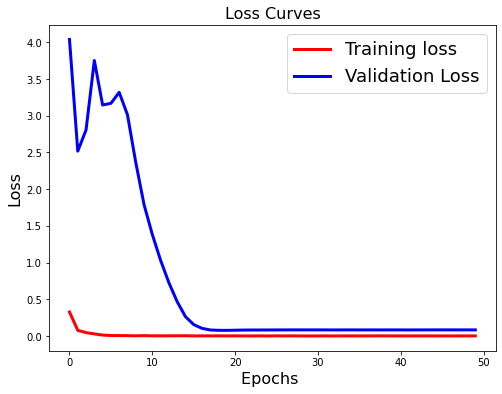

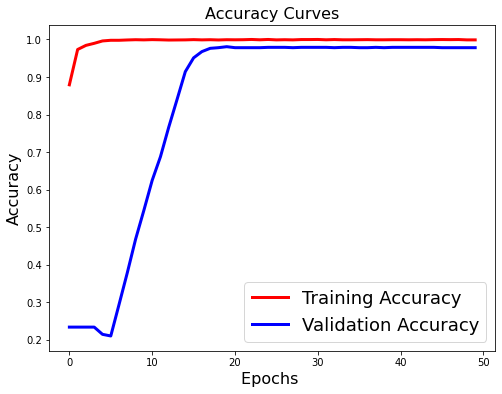

In [ ]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()

## Loading and Saving Model 

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('D:/bt project/temp/temp/brain-tumour-webapp-main/models/modelres50.h5')
model.save('D:/bt project/temp/temp/brain-tumour-webapp-main/models/modelres50.h5')

In [ ]:
import seaborn as sns
predicted_classes = np.argmax(model.predict(x_test), axis = 1)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes,target_names=['glioma','meningioma','no_tumor','pituitary']))

              precision    recall  f1-score   support

      glioma       0.99      0.97      0.98       300
  meningioma       0.97      0.99      0.98       306
    no_tumor       1.00      1.00      1.00       405
   pituitary       1.00      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311

